<a href="https://colab.research.google.com/github/DiyanshuKundu/Erosion-Decal/blob/main/Erosion_Decal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install noise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56275 sha256=ae265d15a5700e3b90578f43a7531a6225176561aab0e49f0ce301bbf1b5aa47
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


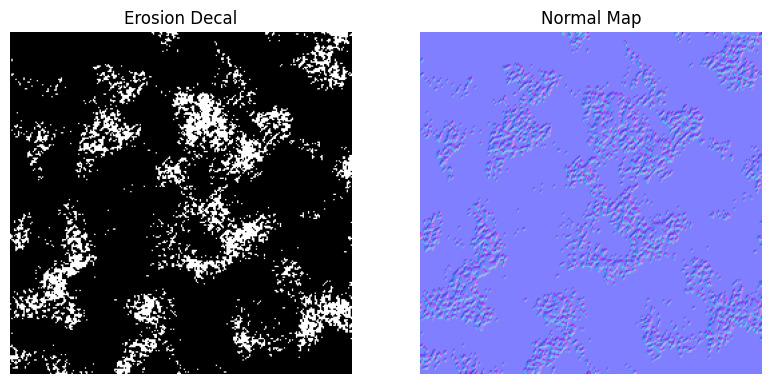

Normal map saved as 'erosion_normal_map.png'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from noise import snoise2
from PIL import Image

def generate_perlin_noise(shape, scale=10, octaves=20, persistence=0.5, lacunarity=2.0):
    height, width = shape
    noise = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            n = 0
            scales = [1, 0.5, 0.4, 0.05]
            strength = [1, 0.9, 0.1, 1]
            for (s, strength) in zip(scales, strength):
                n += snoise2(
                    x / (scale * s), y / (scale * s), octaves=octaves, persistence=persistence, lacunarity=lacunarity
                ) * strength
            noise[y][x] = n / len(scales)
    return noise

def create_erosion_decal(size, edge_sharpness=2.0, noise_scale=10, noise_strength=0.5):
    y, x = np.ogrid[-1:1:size[0]*1j, -1:1:size[1]*1j]
    base = 1 - np.sqrt(x*x + y*y)
    base = np.clip(base, 0, 1)
    base = np.power(base, edge_sharpness)
    noise = generate_perlin_noise(size, scale=noise_scale)
    noise = [(x + 1) / 2 for x in noise]
    threshold = 0.57
    for y in range(size[1]):
        for x in range(size[0]):
            noise[y][x] = (1 if noise[y][x] > threshold else 0)
    return noise

def plot_step(data, title, subplot_position):
    plt.subplot(subplot_position)
    plt.imshow(data, cmap='gray')
    plt.title(title)
    plt.axis('off')

def convert_to_normal_map(height_map):
    gradient_x = np.gradient(height_map, axis=1)
    gradient_y = np.gradient(height_map, axis=0)
    normal_map = np.dstack((-gradient_x, -gradient_y, np.ones_like(height_map)))
    normal_map /= np.linalg.norm(normal_map, axis=2, keepdims=True)
    normal_map = (normal_map + 1) / 2  # Convert from [-1, 1] to [0, 1] range
    return (normal_map * 255).astype(np.uint8)

# Set parameters
size = (256, 256)
edge_sharpness = 2.0
noise_scale = 100
noise_strength = 0.5

# Create erosion decal
decal = create_erosion_decal(size, edge_sharpness, noise_scale, noise_strength)

# Convert decal to normal map
normal_map = convert_to_normal_map(decal)

# Plot results
plt.figure(figsize=(15, 5))
plot_step(decal, 'Erosion Decal', 131)
plt.subplot(132)
plt.imshow(normal_map)
plt.title('Normal Map')
plt.axis('off')
plt.show()

# Save normal map as an image
Image.fromarray(normal_map).save('erosion_normal_map.png')
print("Normal map saved as 'erosion_normal_map.png'")